In [1]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import cm
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import warnings 
warnings.filterwarnings('ignore')

#File Tools for local
import pandas as pd
import sys

#Sampling
from pyDOE import lhs
from scipy.interpolate import griddata
from smt.sampling_methods import LHS
import random

import torch
from botorch.models.gp_regression import HeteroskedasticSingleTaskGP
from botorch.models.gp_regression import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.fit import fit_gpytorch_model
from botorch.utils.transforms import normalize
from gpytorch.mlls import ExactMarginalLogLikelihood


In [2]:
# Import all data
data_r1 = pd.read_csv('../Round1/extracted_data_round1.csv')
data_r2A = pd.read_csv('../Round2/ModelA/extracted_data_round2A.csv')
data_r3A = pd.read_csv('../Round3/ModelA/extracted_data_round3A.csv')
data_redo =pd.read_csv('../Round_Redo/extracted_data_round_redo.csv')

raw_data01 = data_r1[['01_time','01_temp','01_sulf','01_anly','01_yield product']].rename(columns = {'01_time':"time",'01_temp':"temp",'01_sulf':"sulf",'01_anly':"anly",'01_yield product':"yield product"})
raw_data2A = data_r2A[['2A_time','2A_temp','2A_sulf','2A_anly','2A_yield product']].rename(columns = {'2A_time':"time",'2A_temp':"temp",'2A_sulf':"sulf",'2A_anly':"anly",'2A_yield product':"yield product"})
raw_data3A = data_r3A[['3A_time','3A_temp','3A_sulf','3A_anly','3A_yield product']].rename(columns = {'3A_time':"time",'3A_temp':"temp",'3A_sulf':"sulf",'3A_anly':"anly",'3A_yield product':"yield product"})
raw_dataredo = data_redo[['model ID','time','temp','sulf','anly','yield product']]

# Deviec set up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32


In [3]:
avg_data01 = raw_data01.rolling(window=3).mean().iloc[2::3].reset_index(drop=True)[['time','temp','sulf','anly','yield product']]
std_data01 = raw_data01 .rolling(window=3).std().iloc[2::3].reset_index(drop=True)[['yield product']].rename(columns = {'yield product':"var yield"})
data01 = pd.concat([avg_data01, std_data01], axis=1)

avg_data2A = raw_data2A .rolling(window=3).mean().iloc[2::3].reset_index(drop=True)[['time','temp','sulf','anly','yield product']]
std_data2A = raw_data2A .rolling(window=3).std().iloc[2::3].reset_index(drop=True)[['yield product']].rename(columns = {'yield product':"var yield"})
data2A = pd.concat([avg_data2A, std_data2A], axis=1)

avg_data3A = raw_data3A.rolling(window=3).mean().iloc[2::3].reset_index(drop=True)[['time','temp','sulf','anly','yield product']]
std_data3A = raw_data3A.rolling(window=3).std().iloc[2::3].reset_index(drop=True)[['yield product']].rename(columns = {'yield product':"var yield"})
data3A = pd.concat([avg_data3A, std_data3A], axis=1)

avg_data_redo = raw_dataredo.rolling(window=3).mean().iloc[2::3].reset_index(drop=True)[['model ID','time','temp','sulf','anly','yield product']]
std_data_redo = raw_dataredo.rolling(window=3).std().iloc[2::3].reset_index(drop=True)[['yield product']].rename(columns = {'yield product':"var yield"})
redo_data = pd.concat([avg_data_redo, std_data_redo], axis=1)

# Add a category column to each dataframe before concatenating
data01['category'] = 'R 01'
data2A['category'] = 'R 2A'
data3A['category'] = 'R 3A'
redo_data['category'] = 'redo'

# Concatenate the dataframes
modelA_df = pd.concat([data01, data2A, data3A], axis=0, ignore_index=True)
outlier_ID = [78, 80, 88, 89] 

# Replace outliers in modelA_df with their corresponding model IDs in redo_data
for outlier_id in outlier_ID:
    # Find the corresponding row in redo_data
    replacement_row = redo_data[redo_data['model ID'] == outlier_id]
    if not replacement_row.empty:
        # Replace the row in modelA_df
        modelA_df.loc[modelA_df['time'] == replacement_row['time'].values[0], 
                      ['time', 'temp', 'sulf', 'anly', 'yield product', 'var yield', 'category']] = replacement_row[['time', 'temp', 'sulf', 'anly', 'yield product', 'var yield', 'category']].values


# Get high yield samples
high_yield_df = modelA_df[modelA_df['yield product'] > 0.9]
high_yield_df 

data3A = modelA_df[(modelA_df['category'] == 'R 3A').idxmax():(modelA_df['category'] == 'R 3A').idxmax()+15].reset_index(drop=True)

# Model Sets
set_dataA = pd.concat([data01, data2A, data3A], axis=0, ignore_index=True)


>## 2D slices

In [4]:
def gp_evaluate(gp, test_x):
    # Get posterior predictions
    gp.eval()
    with torch.no_grad():
        posterior = gp.posterior(test_x)

    mean = posterior.mean.squeeze().numpy()
    lower, upper = posterior.mvn.confidence_region()
    var = posterior.variance.squeeze().numpy()

    return mean, var

# Function to generate input data based on variable combination
def generate_input_data(A, B, c, d, combination):
    if combination == ('time', 'temp'):
        return torch.tensor(np.array([[A[i, j], B[i, j], c, d] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('time', 'sulf'):
        return torch.tensor(np.array([[A[i, j], c, B[i, j], d] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)        
    elif combination == ('time', 'anly'):
        return torch.tensor(np.array([[A[i, j], d, B[i, j], c ] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('temp', 'sulf'):
        return torch.tensor(np.array([[d, A[i, j], B[i, j], c] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('temp', 'anly'):
        return torch.tensor(np.array([[d, A[i, j], c, B[i, j]] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('sulf', 'anly'):
        return torch.tensor(np.array([[d, c,A[i, j], B[i, j]] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)


def staircase_plot_with_histograms(select, means, var, train_x, train_y, train_yvar, test_x, color, name):
    if select == 'mean':
        versions = means
        cmap_name = color
        y = train_y.numpy()
    elif select == 'var':
        versions = [var] * len(means)  # Use the same variance for all means
        cmap_name = 'seismic'
        y = train_yvar.numpy()

    num_features = train_x.shape[1]  # Assuming 4D input
    feature_names = ["time", "temp", "sulf", "anly"]
    
    fig, axes = plt.subplots(num_features, num_features, figsize=(12, 10))
    count = 0
    for i in range(num_features):
        for j in range(num_features):
            ax = axes[i, j]
            if i < j:  # Upper triangle (leave empty)
                ax.axis('off')
            elif i == j:  # Diagonal (histograms)
                ax.hist(train_x[:, i].numpy(), bins=10, color='gray', edgecolor='black', alpha=0.7)
                ax.set_xlabel(feature_names[i])
                ax.set_box_aspect(1)  # Set the aspect ratio to be equal (cube-shaped)
                ax.set_ylabel("Frequency")
            else:  # Lower triangle (pairwise scatter plots)
                for version in versions:
                    ax.scatter(train_x[:, j].numpy(), train_x[:, i].numpy(), c=y, cmap=cmap_name, s=50, alpha=0.5,marker='o')
                    sc = ax.contourf(A, B, means[count].reshape(num_points, num_points), cmap=cmap_name, alpha=0.7, levels=10,vmax=1, vmin=0)
                fig.colorbar(sc, ax=ax, orientation='vertical')
                ax.set_xlabel(feature_names[j])
                ax.set_ylabel(feature_names[i])
                ax.set_box_aspect(1)
                count += 1
            plt.tight_layout()

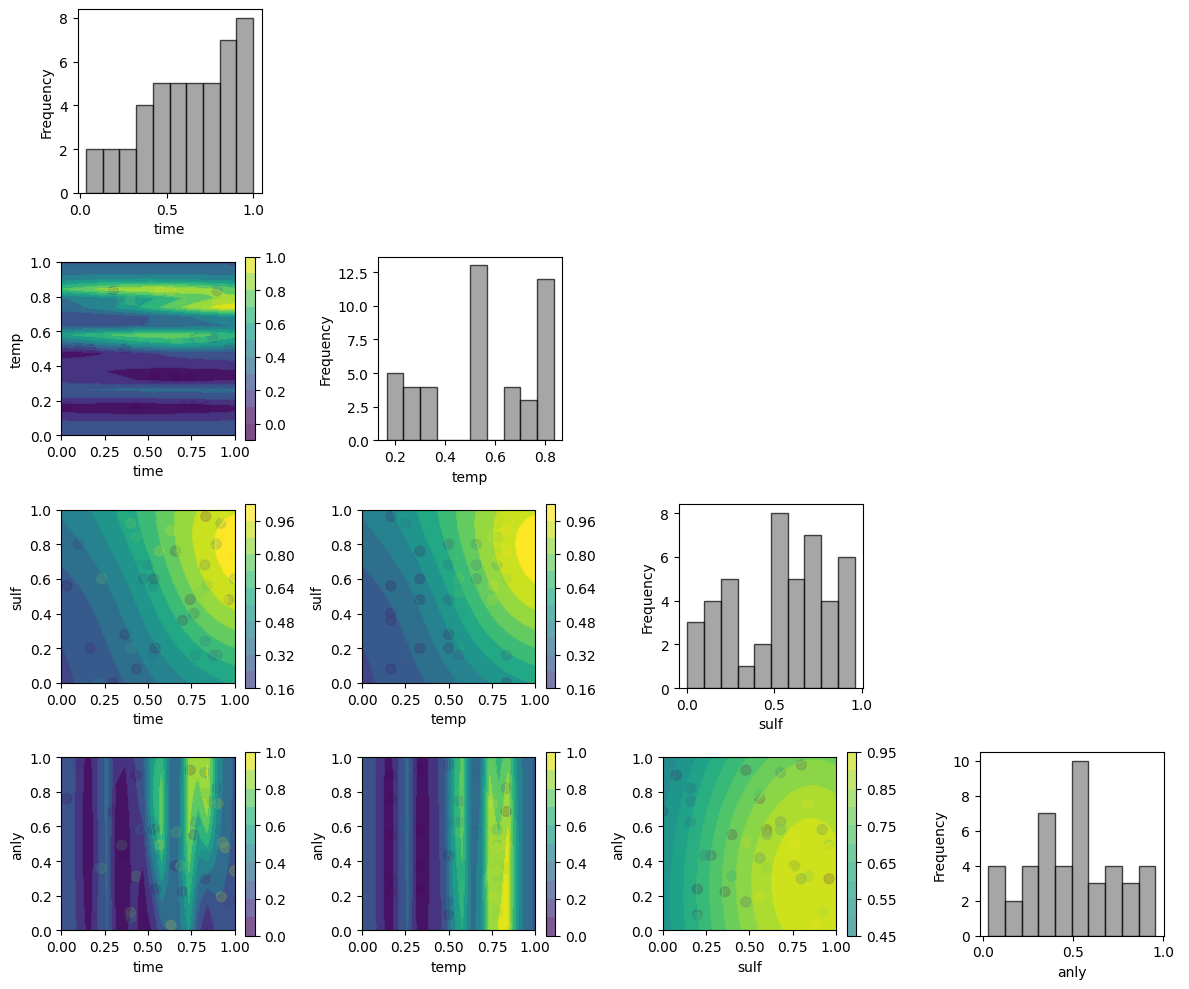

In [5]:
bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100.,100.]], dtype=dtype, device=device) #torch.stack([torch.zeros(4), 100 * torch.ones(4)])

x = torch.tensor([set_dataA['time'],set_dataA['temp'],set_dataA['sulf'],set_dataA['anly']],dtype=torch.float32).T#
norm_x = normalize(x, bounds)
y = torch.tensor(set_dataA['yield product'],dtype=torch.float32).reshape(-1,1)
yvar = torch.tensor(set_dataA['var yield'],dtype=torch.float32).reshape(-1,1)

train_x = torch.tensor(norm_x, dtype=dtype).to(device=device, dtype=dtype)
train_y = torch.tensor(y, dtype=dtype)
train_yvar = torch.tensor(yvar, dtype=dtype)

## Create the surrogate model
gp_model = HeteroskedasticSingleTaskGP(norm_x, train_y, train_yvar, outcome_transform=None, input_transform=None) 
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_model(mll)

# Visualized the Model
# Generate a grid
num_points = 20  # Points per axis for plotting
a = np.linspace(0, 1, num_points)
b = np.linspace(0, 1, num_points)
c_fixed =  0.75  # Example fixed value for c - three temperatures
d_fixed =  0.75 # Example fixed value for d - three temperatures

# # Create meshgrid for a, b
A, B = np.meshgrid(a, b)

# Define all combinations of variables for triple pair plots
variable_combinations = [('time', 'temp'), ('time', 'sulf'), ('time','anly'), ('temp', 'sulf'), ('temp','anly'), ('sulf', 'anly')]
feature_names = ['time', 'temp', 'sulf', 'anly']

mean_values = []
var_values = []
for combination in variable_combinations:
    input_data = generate_input_data(A, B, c_fixed, d_fixed, combination)
    mean, var =  gp_evaluate(gp_model, input_data)
    mean_values.append(mean)
    var_values.append(var)

staircase_plot_with_histograms('mean', mean_values, var_values, train_x, train_y, train_yvar , input_data, 'viridis', f"Combination: {combination}")


>## 4 dimentional Reperesntation

In [14]:
# Normalize the data
bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100.,100.]], dtype=torch.float32) 

def data_prep(df,x1,x2,x3,x4,bounds):
    x1 = torch.tensor([df[x1]], dtype=torch.float32).T
    x2 = torch.tensor([df[x2]], dtype=torch.float32).T
    x3 = torch.tensor([df[x3]], dtype=torch.float32).T
    x4 = torch.tensor([df[x4]], dtype=torch.float32).T

    train_x = torch.hstack([x1, x2, x3, x4])
    train_y = torch.tensor(df['yield product'], dtype=torch.float32).reshape(-1, 1)
    train_yvar = torch.tensor(df['var yield'], dtype=torch.float32).reshape(-1, 1)

    norm_x = normalize(train_x, bounds)

    return norm_x, train_y, train_yvar

# Function to generate input data based on variable combination
def generate_input_data(A, B, c, d, combination):
    if combination == ('time', 'sulf', 'anly'):
        return torch.tensor(np.array([[A[i, j], d, B[i, j], c ] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('sulf', 'anly', 'time'):
        return torch.tensor(np.array([[d, A[i, j], B[i, j], c] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('time', 'anly','time'):
        return torch.tensor(np.array([[A[i, j], c,  B[i, j], d] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)

def gp_4d(train_x, train_y, train_yvar, test_x):
    # Define the initial GP model
    gp = HeteroskedasticSingleTaskGP(train_X=train_x, train_Y=train_y, train_Yvar=train_yvar) 
    #gp = SingleTaskGP(train_X=train_x, train_Y=train_y, train_Yvar=train_yvar, covar_module=kernel) 
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    # Get posterior predictions
    gp.eval()
    with torch.no_grad():
        posterior = gp.posterior(test_x)

    mean = posterior.mean.squeeze().numpy()
    lower, upper = posterior.mvn.confidence_region()
    var = posterior.variance.squeeze().numpy()

    return mean, var

def create_sclices(norm_x, out_y, noise_y,A,B,c,d_fixed,combination):
    mean_values = []
    var_values = []
    for c in c_slices:
        input_data = generate_input_data(A, B, c, d_fixed, combination)
        mean, var = gp_4d(norm_x, out_y, noise_y, input_data)
        mean_values.append(mean.reshape(A.shape))  # Reshape to match the grid
        var_values.append(var.reshape(A.shape))  # Reshape to match the grid

    return mean_values, var_values


def slcied_plotting(mean_vals1,mean_vals2,mean_vals3,mean_vals4,mean_vals5,combination,minmax,colormap):
    global_min = minmax[0]
    global_max = minmax[1]
    # Create a new figure with subplots for each combination
    fig = make_subplots(rows=1, cols=5, subplot_titles=('temp: 0', 'temp: 0.25','temp: 0.5', 'temp: 0.75','temp: 1.0'),
                    specs=[[{'type': 'surface'}, {'type': 'surface'},{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]])

    for i, (c, y_grid1, y_grid2, y_grid3, y_grid4, y_grid5) in enumerate(zip(c_slices, mean_vals1,mean_vals2,mean_vals3,mean_vals4,mean_vals5), start=1):
        fig.add_trace(go.Surface(
            x=A,
            y=B,
            z=c * np.ones_like(A),  # Z-coordinate for slicing
            surfacecolor=y_grid1,  # Use predicted `y` as contour
            colorscale=colormap,
            cmin=global_min,
            cmax=global_max,
            showscale=True if i == 1 else False,  # Show color scale only on the first slice
            #   colorbar_x=0.45,
            opacity=0.7
        ), row=1, col=1)
  
        fig.add_trace(go.Surface(
            x=A,
            y=B,
            z=c * np.ones_like(A),  # Z-coordinate for slicing
            surfacecolor=y_grid2,  # Use predictediance as contour
            cmin=global_min,
            cmax=global_max,
            colorscale=colormap,
            showscale=True if i == 1 else False,  # Show color scale only on the first slice
            #colorbar_x=0.45,
            opacity=0.7
        ), row=1, col=2)

        fig.add_trace(go.Surface(
            x=A,
            y=B,
            z=c * np.ones_like(A),  # Z-coordinate for slicing
            surfacecolor=y_grid3,  # Use predictediance as contour
            cmin=global_min,
            cmax=global_max,
            colorscale=colormap,
            showscale=True if i == 1 else False,  # Show color scale only on the first slice
            opacity=0.7
        ), row=1, col=3)

        fig.add_trace(go.Surface(
            x=A,
            y=B,
            z=c * np.ones_like(A),  # Z-coordinate for slicing
            surfacecolor=y_grid4,  # Use predictediance as contour
            cmin=global_min,
            cmax=global_max,
            colorscale=colormap,
            showscale=True if i == 1 else False,  # Show color scale only on the first slice
            opacity=0.7
        ), row=1, col=4)

        fig.add_trace(go.Surface(
            x=A,
            y=B,
            z=c * np.ones_like(A),  # Z-coordinate for slicing
            surfacecolor=y_grid5,  # Use predictediance as contour
            cmin=global_min,
            cmax=global_max,
            colorscale=colormap,
            showscale=True if i == 1 else False,  # Show color scale only on the first slice
            opacity=0.7
        ), row=1, col=5)
        

    fig.update_layout(
        height=400,
        width=1300,
        margin=dict(l=50, r=50, b=50, t=50),
        scene=dict(
            xaxis_title=combination[0],
            yaxis_title=combination[1],
            zaxis_title=combination[2]
        ),
        scene2=dict(
            xaxis_title=combination[0],
            yaxis_title=combination[1],
            zaxis_title=combination[2]
        ),
        scene3=dict(
            xaxis_title=combination[0],
            yaxis_title=combination[1],
            zaxis_title=combination[2]
        ),
        scene4=dict(
            xaxis_title=combination[0],
            yaxis_title=combination[1],
            zaxis_title=combination[2]
        ),
        scene5=dict(
            xaxis_title=combination[0],
            yaxis_title=combination[1],
            zaxis_title=combination[2]
        )
    )

    fig.show()

comb_id = 0

In [10]:
# Generate a grid for demonstration (adjust as needed for your data range)
num_points = 15  # Points per axis for plotting
a = np.linspace(0, 1, num_points)
b = np.linspace(0, 1, num_points)
c_slices = np.linspace(0, 1, 12)  # Slicing variable
d_fixed =  0.5 # Example fixed value for d - three temperatures

# # Create meshgrid for a, b
A, B = np.meshgrid(a, b)
# Define all combinations of variables for triple pair plots
variable_combinations = [('time', 'sulf', 'anly'),('sulf', 'anly', 'time'),('time', 'anly', 'sulf')]
fixed_variable = ['temp']


In [12]:
# Create the training data
norm_0, out_0, noise_0 = data_prep(data01,'time','temp','sulf','anly',bounds)

mean_vals1, var_vals1 = create_sclices(norm_0, out_0, noise_0, A,B,c_slices,0.0 ,variable_combinations[comb_id]) # fixed variable: temp = 0.0
mean_vals2, var_vals2 = create_sclices(norm_0, out_0, noise_0, A,B,c_slices,0.25,variable_combinations[comb_id]) # fixed variable: temp = 0.25
mean_vals3, var_vals3 = create_sclices(norm_0, out_0, noise_0, A,B,c_slices,0.5 ,variable_combinations[comb_id]) # fixed variable: temp = 0.50
mean_vals4, var_vals4 = create_sclices(norm_0, out_0, noise_0, A,B,c_slices,0.75,variable_combinations[comb_id]) # fixed variable: temp = 0.75
mean_vals5, var_vals5 = create_sclices(norm_0, out_0, noise_0, A,B,c_slices,1.0 ,variable_combinations[comb_id]) # fixed variable: temp = 1.0

slcied_plotting(mean_vals1,mean_vals2,mean_vals3,mean_vals4,mean_vals5,variable_combinations[comb_id],[0,1],'Viridis')
abs_min = min([np.min(var_vals1),np.min(var_vals2),np.min(var_vals3),np.min(var_vals4),np.min(var_vals5)])
abs_max = max([np.max(var_vals1),np.max(var_vals2),np.max(var_vals3),np.max(var_vals4),np.max(var_vals5)])
slcied_plotting(var_vals1,var_vals2,var_vals3,var_vals4,var_vals5,variable_combinations[comb_id],[abs_min,abs_max],'Viridis_r')


In [ ]:
set_data2A = pd.concat([data01, data2A ], ignore_index=True)
norm_2A, out_2A, noise_2A = data_prep(set_data2A,'time','temp','sulf','anly',bounds)

mean_vals1, var_vals1 = create_sclices(norm_2A, out_2A, noise_2A, A,B,c_slices,0.0 ,variable_combinations[comb_id]) # fixed variable: temp = 0.00
mean_vals2, var_vals2 = create_sclices(norm_2A, out_2A, noise_2A, A,B,c_slices,0.25,variable_combinations[comb_id]) # fixed variable: temp = 0.25
mean_vals3, var_vals3 = create_sclices(norm_2A, out_2A, noise_2A, A,B,c_slices,0.5 ,variable_combinations[comb_id]) # fixed variable: temp = 0.50
mean_vals4, var_vals4 = create_sclices(norm_2A, out_2A, noise_2A, A,B,c_slices,0.75,variable_combinations[comb_id]) # fixed variable: temp = 0.75
mean_vals5, var_vals5 = create_sclices(norm_2A, out_2A, noise_2A, A,B,c_slices,1.0 ,variable_combinations[comb_id]) # fixed variable: temp = 1.00

slcied_plotting(mean_vals1,mean_vals2,mean_vals3,mean_vals4,mean_vals5,variable_combinations[comb_id],[0,1],'Viridis')

abs_min = min([np.min(var_vals1),np.min(var_vals2),np.min(var_vals3),np.min(var_vals4),np.min(var_vals5)])
abs_max = max([np.max(var_vals1),np.max(var_vals2),np.max(var_vals3),np.max(var_vals4),np.max(var_vals5)])
slcied_plotting(var_vals1,var_vals2,var_vals3,var_vals4,var_vals5,variable_combinations[comb_id],[abs_min,abs_max],'Viridis_r')

In [13]:
set_data3A = pd.concat([data01, data2A, data3A], axis=0, ignore_index=True)
norm_3A, out_3A, noise_3A = data_prep(set_data3A,'time','temp','sulf','anly',bounds)
mean_vals1, var_vals1 = create_sclices(norm_3A, out_3A, noise_3A, A,B,c_slices,0.0 ,variable_combinations[comb_id]) # fixed variable: temp = 0.0
mean_vals2, var_vals2 = create_sclices(norm_3A, out_3A, noise_3A, A,B,c_slices,0.25,variable_combinations[comb_id]) # fixed variable: temp = 0.25
mean_vals3, var_vals3 = create_sclices(norm_3A, out_3A, noise_3A, A,B,c_slices,0.5 ,variable_combinations[comb_id]) # fixed variable: temp = 0.50
mean_vals4, var_vals4 = create_sclices(norm_3A, out_3A, noise_3A, A,B,c_slices,0.75,variable_combinations[comb_id]) # fixed variable: temp = 0.75
mean_vals5, var_vals5 = create_sclices(norm_3A, out_3A, noise_3A, A,B,c_slices,1.0 ,variable_combinations[comb_id]) # fixed variable: temp = 1.0

slcied_plotting(mean_vals1,mean_vals2,mean_vals3,mean_vals4,mean_vals5,variable_combinations[comb_id],[0,1],'Viridis')

abs_min = min([np.min(var_vals1),np.min(var_vals2),np.min(var_vals3),np.min(var_vals4),np.min(var_vals5)])
abs_max = max([np.max(var_vals1),np.max(var_vals2),np.max(var_vals3),np.max(var_vals4),np.max(var_vals5)])
slcied_plotting(var_vals1,var_vals2,var_vals3,var_vals4,var_vals5,variable_combinations[comb_id],[abs_min,abs_max],'Viridis_r')